In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pdb import set_trace

In [3]:
mnist = tf.keras.datasets.mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train.min(), y_train.max())
n, m = x_train.shape
c = y_train.max() + 1
print(n, m, c)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000,) (10000, 784) (10000,) 0 9
60000 784 10


In [4]:
def normalize(x, m, s): return (x - m) / s

In [5]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(33.318421449829934, 78.56748998339798)

In [6]:
x_train = normalize(x_train, train_mean, train_std)
x_test  = normalize(x_test,  train_mean, train_std)

In [7]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(-3.064638490070051e-17, 0.9999999999999998)

In [8]:
x_train.shape

(60000, 784)

In [9]:
# # in order to run the kernel, 5 x 5 - see bellow cells, I reshape 
# # into 60000 x 28 x 28 x 1, the last dimension is because we have only one channel
# x_train = tf.reshape(x_train, [x_train.shape[0], 28, 28])[..., None]
# x_test  = tf.reshape(x_test , [x_test.shape[0], 28, 28])[..., None]
# x_train.shape, x_test.shape

In [10]:
# num hidden layer
nh = 50

In [11]:
class Model(tf.keras.Model):
    def __init__(self, nh, n_out):        
        super().__init__()
        self.lrs = [tf.keras.layers.Dense(nh), tf.keras.layers.ReLU(), tf.keras.layers.Dense(n_out)]
        
    def call(self, x):
        for l in self.lrs: x = l(x)
        return x
    
model = Model(nh, 10)

In [12]:
# activate the model
pred = model(x_train)

W0102 13:09:31.903322 139782540642048 base_layer.py:1814] Layer model is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [13]:
model.layers

In [14]:
len(model.variables)

4

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  39250     
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [16]:
def softmax(x): return tf.math.exp(x)/tf.math.reduce_sum(tf.math.exp(x), 1, keepdims=True)

In [17]:
def log_softmax(x): return tf.math.log(softmax(x))

In [18]:
sm_pred = log_softmax(pred)

In [19]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

In [20]:
# the first element in y_train[:3] above is the element we want (which is 5):
sm_pred[0]

<tf.Tensor: id=65, shape=(10,), dtype=float32, numpy=
array([-1.2655183, -1.7178358, -4.6140556, -1.8788285, -2.149867 ,
       -2.792309 , -3.8598835, -3.129559 , -4.4795275, -2.1049902],
      dtype=float32)>

In [21]:
# so we want
sm_pred[0][4]

<tf.Tensor: id=73, shape=(), dtype=float32, numpy=-2.149867>

In [22]:
# so instead of calculating -sum(x * log(x)) and do "waste time" calculating stuff like 0 * log(q)
# Jeremy presents a solution in the notebook: in pytorch : sm_pred[[0, 1, 2], [5, 0, 4]]
# In tensorflow this can be done as follow:
# you want to collect ONLY relevant ground true probabilities (==1.0), 
# so in the example above, we need to gather for the first row of sm_pred, position 5
# from the 2 row position 0
# from the 3rd row position 4
# in tf this can be done as follow:
# tf.gather_nd(sm_pred, [[0, 5], [1, 0], [2, 4]])
print(tf.gather_nd(sm_pred, np.array([[0, 5], [1, 0], [2, 4]])))
# or in a more formalized way:
print(tf.gather_nd(sm_pred, np.stack((np.arange(len(y_train[:3])), y_train[:3])).transpose()))

tf.Tensor([-2.792309 -2.122984 -3.45119 ], shape=(3,), dtype=float32)
tf.Tensor([-2.792309 -2.122984 -3.45119 ], shape=(3,), dtype=float32)


In [23]:
# so instead of summing unnecessary elements, there is a better way (as shown above) of
# calculating the negative log likelihood (nll):
def nll(input, target): 
    
    # rearange target such that it looks as above:
    pick = np.stack((np.arange(len(target)), target)).transpose()
                    
    # nll
    return -tf.math.reduce_mean(tf.gather_nd(input, pick))

In [24]:
print(nll(sm_pred, y_train[:3]))
print(-tf.math.reduce_mean(tf.gather_nd(sm_pred, np.array([[0, 5], [1, 0], [2, 4]]))))

tf.Tensor(2.7888277, shape=(), dtype=float32)
tf.Tensor(2.7888277, shape=(), dtype=float32)


In [25]:
loss = nll(sm_pred, y_train)
loss

<tf.Tensor: id=92, shape=(), dtype=float32, numpy=2.7140043>

In [26]:
# since it's the log of the softmax, it can be rewritten as:
def log_softmax(x): return x - tf.math.log(tf.math.reduce_sum(tf.math.exp(x), 1, keepdims=True))

In [27]:
sm_pred = log_softmax(pred)

In [28]:
sm_pred[0] # same as above

<tf.Tensor: id=101, shape=(10,), dtype=float32, numpy=
array([-1.2655182, -1.7178357, -4.6140556, -1.8788284, -2.149867 ,
       -2.7923088, -3.8598835, -3.1295588, -4.479527 , -2.10499  ],
      dtype=float32)>

In [29]:
# log sum exp trick:
# high floating points number are not accurate, so the logsumexp trick comes to the rescue
# see https://course.fast.ai/videos/?lesson=9 at 40 min
def logsumexp(x):
    # find the maximum:
    m = tf.math.reduce_max(x)
    
    # it's just a trick that extract the maximum out of the sum:
    return m + tf.math.log(tf.math.reduce_sum(tf.math.exp(x-m), 1, keepdims=True))

In [30]:
# my logsumexp
logsumexp(pred)

<tf.Tensor: id=109, shape=(60000, 1), dtype=float32, numpy=
array([[3.0857718],
       [2.619653 ],
       [3.1994472],
       ...,
       [3.4174674],
       [2.4986951],
       [2.9030917]], dtype=float32)>

In [31]:
# tf logsumexp
tf.math.reduce_logsumexp(pred, 1, keepdims=True)

<tf.Tensor: id=121, shape=(60000, 1), dtype=float32, numpy=
array([[3.0857716],
       [2.6196532],
       [3.1994472],
       ...,
       [3.4174674],
       [2.4986951],
       [2.903092 ]], dtype=float32)>

In [32]:
def log_softmax(x): return x - tf.math.reduce_logsumexp(x, 1, keepdims=True)

In [33]:
print(nll(log_softmax(pred), y_train))
print(loss)

tf.Tensor(2.7140038, shape=(), dtype=float32)
tf.Tensor(2.7140043, shape=(), dtype=float32)


In [34]:
# in tensorflow, nll is a combination of mean + softmax + cross entropy.
# softmax + cross entropy are combined into one function called
# tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred)
# HOWEVER, y_train must be one hot encoded and to calculate the loss
# we need to calculate the mean on the result on tf.nn.softmax_cross_entropy_with_logits
# interesting discussion on stackoverflow:
# https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits
# Using tf:
print(tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(y_train, 10), pred)))
# Using Keras:
print(tf.math.reduce_mean(tf.keras.losses.categorical_crossentropy(tf.one_hot(y_train, 10), softmax(pred))))

tf.Tensor(2.7140043, shape=(), dtype=float32)
tf.Tensor(2.7140043, shape=(), dtype=float32)


# Basic Training Loop

Training is repeating over the following steps:
1. get the outputof the model on a batch of inputs
2. compare the output to the labels we have and compute a loss
3. calculate the gradients of the loss with respect to every parameter of the model
4. update said parameters with those gradients to make them a little bit better

In [35]:
# here target MUST be one hot encoded
# corss entropy loss
def cross_entropy(targets, predictions):
    return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predictions))

In [36]:
# here the target MUST NOT BE one hot encoded
def accuracy(targets, predictions):
    y_predictions = tf.cast(tf.argmax(predictions, axis=1), dtype=tf.float32)
    y_targets = tf.cast(targets, dtype=tf.float32)
    return tf.math.reduce_mean(tf.cast(tf.math.equal( y_predictions, y_targets) , dtype=tf.float32))

In [37]:
bs = 64
xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(<tf.Tensor: id=219, shape=(10,), dtype=float32, numpy=
 array([ 1.8202534 ,  1.3679359 , -1.528284  ,  1.2069432 ,  0.93590456,
         0.29346266, -0.7741119 , -0.0437873 , -1.3937556 ,  0.98078144],
       dtype=float32)>, TensorShape([64, 10]))

In [38]:
yb = y_train[:bs]
cross_entropy(tf.one_hot(yb, 10), preds)

<tf.Tensor: id=258, shape=(), dtype=float32, numpy=2.7845428>

In [39]:
# accuracy percentage
accuracy(yb, preds).numpy()*100

9.375

In [40]:
lr = 0.5 # learning rate
epochs = 1 # how many epochs

In [41]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):        
            start_i = i*bs
            end_i   = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            with tf.GradientTape() as tape:

                # calculate loss
                loss = cross_entropy(tf.one_hot(yb, 10), model(xb))

                # calculate gradient            
                gradients = tape.gradient(loss, model.trainable_variables)

                # update
                for i, parameters in enumerate(model.trainable_variables):                
                    parameters.assign_sub(lr * gradients[i])
            

In [42]:
# the loss is improved as well as the accuracy
fit()
cross_entropy(tf.one_hot(yb, 10), model(xb)).numpy(), accuracy(yb, model(xb)).numpy()*100

(0.15762433, 95.3125)

In [43]:
# the model above can be written as follow using sequential:
# Sequential inherits from Model!!
model = tf.keras.Sequential([tf.keras.layers.Dense(nh), tf.keras.layers.ReLU(), tf.keras.layers.Dense(10)])

In [44]:
# this will replace the lines 18-19 in the fit() function above
b

In [45]:
def fit2():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):        
            start_i = i*bs
            end_i   = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            with tf.GradientTape() as tape:

                # calculate loss
                loss = cross_entropy(tf.one_hot(yb, 10), model(xb))

                # calculate gradient            
                gradients = tape.gradient(loss, model.trainable_variables)

                # update
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [46]:
fit2()
cross_entropy(tf.one_hot(yb, 10), model(xb)).numpy(), accuracy(yb, model(xb)).numpy()*100

W0102 13:09:42.418771 139782540642048 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(0.31112832, 92.1875)

# Dataset

In [47]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

In [48]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_ds = valid_ds.batch(BATCH_SIZE)

In [49]:
# lenght of dataset
nt, nv = len(list(train_ds)), len(list(valid_ds))
nt, nv

(938, 157)

In [50]:
# extract one batch from dataset
image, label = next(iter(train_ds))
image.shape, label.shape

(TensorShape([64, 784]), TensorShape([64]))

label =  4


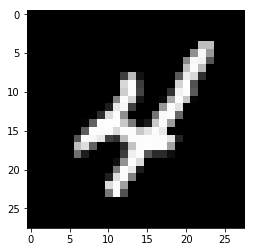

In [51]:
plt.imshow(tf.reshape(image[0], [28, 28]), cmap='gray')
print('label = ', label[0].numpy())

label =  7


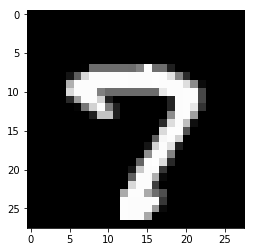

In [52]:
# another way is to loop on the dataset and use take:
for image, label in train_ds.take(1):
    plt.imshow(tf.reshape(image[0], [28, 28]), cmap='gray')
    print('label = ', label[0].numpy())

In [53]:
# in this case, the fit function becomes:
def fit3():
    for epoch in range(epochs):
        
        # loop on the dataset
        for xb, yb in train_ds:            

            with tf.GradientTape() as tape:
                
                # calculate preditions:
                predictions = model(xb)

                # calculate loss
                loss = cross_entropy(tf.one_hot(yb, 10), predictions)

                # calculate gradient            
                gradients = tape.gradient(loss, model.trainable_variables)

                # update
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [54]:
fit3()
cross_entropy(tf.one_hot(yb, 10), model(xb)).numpy(), accuracy(yb, model(xb)).numpy()*100

(0.19535127, 95.3125)

In [55]:
epochs = 5

In [56]:
# in this case, the fit function becomes:
def fit4():
    for epoch in range(epochs):
        
        # loop on the training dataset
        for xb, yb in train_ds:            

            with tf.GradientTape() as tape:
                
                # calculate preditions:
                predictions = model(xb)

                # calculate loss
                loss = cross_entropy(tf.one_hot(yb, 10), predictions)

                # calculate gradient            
                gradients = tape.gradient(loss, model.trainable_variables)

                # update
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # loop on the validation dataset
        tot_loss, tot_acc = 0., 0.    
        for xb, yb in valid_ds:
            
            # predictions
            predictions = model(xb)
            
            # total loss
            tot_loss += cross_entropy(tf.one_hot(yb, 10), predictions).numpy()
            
            # total accuracy
            tot_acc += accuracy(yb, predictions).numpy()*100
       
        # total number of elements in validation set
        print(epoch, tot_loss/nv, tot_acc/nv)
        
    return tot_loss/nv, tot_acc/nv

In [57]:
loss, acc = fit4()

0 0.31415770974627155 91.90883757961784
1 0.3365966368312384 91.49084394904459
2 0.3152571506916907 92.43630573248407
3 0.4686549094618316 88.11703821656052
4 0.5612629761646508 86.38535031847134
